In [ ]:
# !pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
# import transformers as ppb
import seaborn as sns
from time import time
%matplotlib inline
from matplotlib import cm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# DF created

In [ ]:
df=pd.read_csv('train.tsv',sep='\t', header=None)

In [ ]:
df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]

In [ ]:
df.isnull().sum()

id                      0
label                   0
statement               0
subjects                2
speaker                 2
speaker_job_title    2897
state_info           2208
party_affiliation       2
count_1                 2
count_2                 2
count_3                 2
count_4                 2
count_5                 2
context               102
dtype: int64

In [ ]:
# replaces all "null" or "NaN" values with an empty string
df.fillna("", inplace=True)
df.isnull().sum()

id                   0
label                0
statement            0
subjects             0
speaker              0
speaker_job_title    0
state_info           0
party_affiliation    0
count_1              0
count_2              0
count_3              0
count_4              0
count_5              0
context              0
dtype: int64

# Removing rows with more than 350 characters in their statement column

In [ ]:
df['ZipLen'] = df['statement'].astype(str).map(len)
df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context,ZipLen
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,82
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,141
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,105
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release,78
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,54


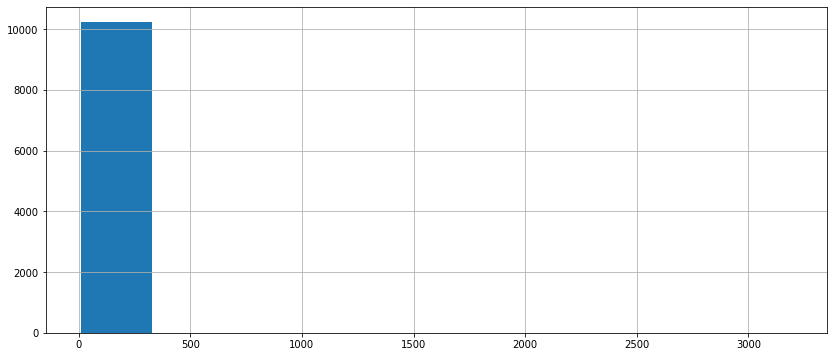

In [ ]:
len_sent = df['ZipLen']
len_sent.hist(figsize=[14,6]);

# There should be some rows with more than 500 characters in statement

In [ ]:
# Removing rows that contains more than 500 characters in statement

df = df[df.ZipLen < 350]

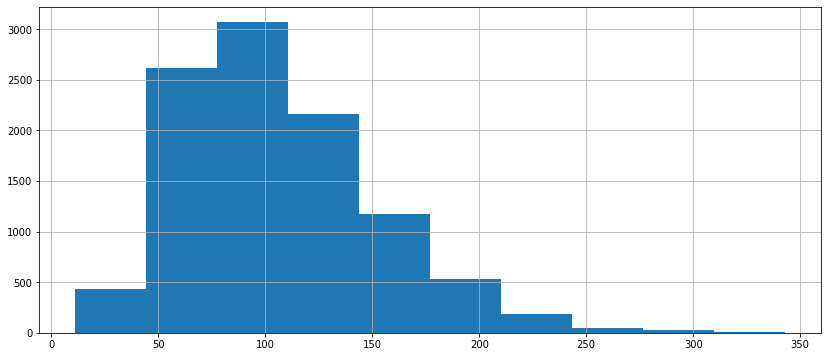

In [ ]:
# Again see the distribution of the statement's length

len_sent = df['ZipLen']
len_sent.hist(figsize=[14,6]);

In [ ]:
df.shape

(10232, 15)

In [ ]:
# Creating "statements" folder in the drive. Read from statement column and create text files in the folder.

df.reset_index()
for i in df['statement'].index:
  with open('./drive/MyDrive/Liar_project/statements/s/'+ '{0:05}'.format(i) + '.txt', 'w') as f:
    f.write(df['statement'][i])

In [ ]:
# %%shell

# head -10 ./statements/s/norm.txt

In [ ]:
# %%shell

# mv ./wordvectors.txt drive/MyDrive/Liar_project/

In [ ]:
# Now that we have all the input data we run go.sh script to create vectors
# The output would be a txt file with 256 features

%%shell

cd drive/MyDrive/Liar_project/
bash go.sh

rm: cannot remove 'temp': No such file or directory
rm: cannot remove 's/norm.txt': No such file or directory
doc2vecc.c: In function ‘ReadVocab’:
doc2vecc.c:322:5: warning: ignoring return value of ‘fscanf’, declared with attribute warn_unused_result [-Wunused-result]
     fscanf(fin, "%lld%c", &vocab[a].cn, &c);
     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting training using file ./statements/s/norm.txt
Vocab size: 2076
Words in train file: 192864
Alpha: 0.000540  Progress: 99.39%  Words/thread/sec: 80.75k  finish embedding training
writing sentence vector ...

real	0m31.362s
user	0m48.882s
sys	0m0.698s


In [ ]:
# Creating features without using np and then converting to np array

# with open("./drive/MyDrive/Liar_project/docvectors.txt", "r") as file:
#     features = [[x for x in line.split()] for line in file]

# features = np.array(features)

In [ ]:
# Create "features" numpy array from vectors 
features = np.loadtxt("./drive/MyDrive/Liar_project/docvectors.txt")
features.shape

(10234, 256)

In [ ]:
# Checking what's inside features

features

array([[-0.067772, -0.04924 ,  0.143165, ..., -0.031487,  0.002473,
         0.034561],
       [-0.058497, -0.06937 ,  0.080409, ..., -0.154229, -0.222704,
         0.072891],
       [-0.100804, -0.022512,  0.190359, ..., -0.188496, -0.15749 ,
         0.041275],
       ...,
       [-0.107243, -0.058853,  0.103258, ..., -0.109131, -0.045648,
        -0.017896],
       [-0.052444, -0.090104,  0.05683 , ..., -0.085006, -0.099827,
         0.057182],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [ ]:
# Removing last row of features
features = features[0:10232]
features.shape

(10232, 256)

In [ ]:
df['label'].shape

(10232,)

In [ ]:
# changing labels to codes

df['label'] = df['label'].astype('category')
df['label'] = df['label'].cat.codes
df['label']

0        1
1        2
2        3
3        1
4        2
        ..
10235    3
10236    3
10237    2
10238    1
10239    4
Name: label, Length: 10232, dtype: int8

In [ ]:
# Creating labels from label column of df

labels = df['label']
labels

0        1
1        2
2        3
3        1
4        2
        ..
10235    3
10236    3
10237    2
10238    1
10239    4
Name: label, Length: 10232, dtype: int8

In [ ]:
labels.shape, df.shape, features.shape

((10232,), (10232, 15), (10232, 256))

# KNN

In [ ]:
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


X = features
y = labels
Xtrain, Xtest, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0, train_size = 0.5)

scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(Xtrain, y_train)
y_pred = knn.predict(Xtest)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.19546520719311963
              precision    recall  f1-score   support

           0       0.17      0.36      0.23       827
           1       0.22      0.28      0.25       997
           2       0.22      0.21      0.21      1057
           3       0.22      0.13      0.16       979
           4       0.11      0.03      0.05       419
           5       0.18      0.08      0.11       837

    accuracy                           0.20      5116
   macro avg       0.19      0.18      0.17      5116
weighted avg       0.20      0.20      0.18      5116

[[295 204 157  94  18  59]
 [319 279 202 105  21  71]
 [382 251 223 103  32  66]
 [324 246 189 123  15  82]
 [156  90  83  48  13  29]
 [302 193 165  92  18  67]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(Xtrain, y_train)
predicted = knn.predict(Xtest)

In [ ]:
acc = accuracy_score(y_test, predicted)

In [ ]:
print(acc)

0.19546520719311963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


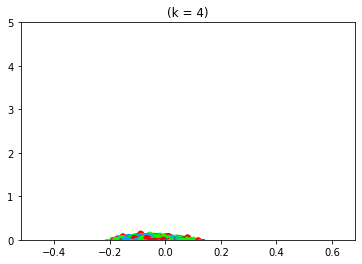

In [ ]:
import matplotlib
matplotlib.use('template')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier


n_neighbors = 4
h = 0.02
X = features
y = labels.values

X_float = X.astype(np.float)
X_float

# # X_float.shape

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_float, y)



# calculate min, max and limits
x_min, x_max = X_float[:, 0].min() - 1, X_float[:, 0].max() + 1
y_min, y_max = X_float[:, 1].min() - 1, X_float[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# xx.ravel
# X_float[:, 0]
# last_column = np.c_[X_float, y]
# last_column = last_column[: , -1]

# last_column

# # predict class using data and kNN classifier
Z = clf.predict(X_float)


# # Put the result into a color plot
# # Z = Z.reshape(X_float[].shape)
plt.figure()
# # plt.pcolormesh(X_float, y, Z, cmap=cmap_light)

# # Plot also the training points
plt.scatter(X_float[:, 0], X_float[:, 1], c=y, cmap=cmap_bold)
plt.xlim(X_float.min(), X_float.max())
plt.ylim(y.min(), y.max())
plt.title("(k = %i)" % (n_neighbors))
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn import datasets, neighbors
# from mlxtend.plotting import plot_decision_regions

# x = features
# y = labels.values
# clf = neighbors.KNeighborsClassifier(n_neighbors=2)
# clf.fit(x, y)

# # Plotting decision region
# # plot_decision_regions(x, y, clf=clf)
# # Adding axes annotations
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Knn with k=3')
# plt.show()

# TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=0)
z = tsne.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10232 samples in 0.004s...
[t-SNE] Computed neighbors for 10232 samples in 4.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10232
[t-SNE] Computed conditional probabilities for sample 2000 / 10232
[t-SNE] Computed conditional probabilities for sample 3000 / 10232
[t-SNE] Computed conditional probabilities for sample 4000 / 10232
[t-SNE] Computed conditional probabilities for sample 5000 / 10232
[t-SNE] Computed conditional probabilities for sample 6000 / 10232
[t-SNE] Computed conditional probabilities for sample 7000 / 10232
[t-SNE] Computed conditional probabilities for sample 8000 / 10232
[t-SNE] Computed conditional probabilities for sample 9000 / 10232
[t-SNE] Computed conditional probabilities for sample 10000 / 10232
[t-SNE] Computed conditional probabilities for sample 10232 / 10232
[t-SNE] Mean sigma: 0.233895
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.765709
[t-SNE] KL d

In [ ]:
z.shape, labels.shape, features.shape

((10232, 2), (10232,), (10232, 256))

### TSNE Plotting

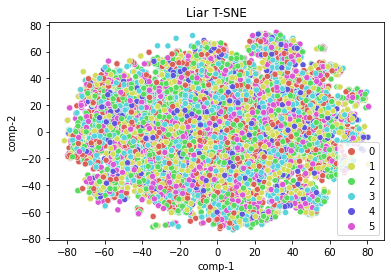

In [ ]:
df1 = pd.DataFrame()
df1["y"] = labels

df1["comp-1"] = z[:,0]

df1["comp-2"] = z[:,1]
sns.scatterplot(x=df1["comp-1"], y=df1["comp-2"], hue=df1.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df1).set(title="Liar T-SNE");

### Another approch of TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10232 samples in 0.004s...
[t-SNE] Computed neighbors for 10232 samples in 5.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10232
[t-SNE] Computed conditional probabilities for sample 2000 / 10232
[t-SNE] Computed conditional probabilities for sample 3000 / 10232
[t-SNE] Computed conditional probabilities for sample 4000 / 10232
[t-SNE] Computed conditional probabilities for sample 5000 / 10232
[t-SNE] Computed conditional probabilities for sample 6000 / 10232
[t-SNE] Computed conditional probabilities for sample 7000 / 10232
[t-SNE] Computed conditional probabilities for sample 8000 / 10232
[t-SNE] Computed conditional probabilities for sample 9000 / 10232
[t-SNE] Computed conditional probabilities for sample 10000 / 10232
[t-SNE] Computed conditional probabilities for sample 10232 / 10232
[t-SNE] Mean sigma: 0.233895
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.765709
[t-SNE] KL d

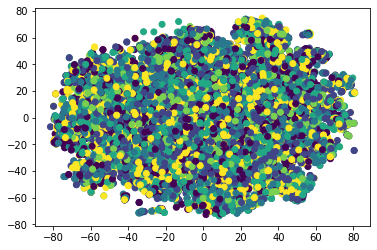

In [ ]:
tsne_results = tsne.fit_transform(features)
tsne_results = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
# tsne_results.shape
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=labels)
plt.show();

#### TSNE using Xtrain and y_train

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5116 samples in 0.002s...
[t-SNE] Computed neighbors for 5116 samples in 0.976s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5116
[t-SNE] Computed conditional probabilities for sample 2000 / 5116
[t-SNE] Computed conditional probabilities for sample 3000 / 5116
[t-SNE] Computed conditional probabilities for sample 4000 / 5116
[t-SNE] Computed conditional probabilities for sample 5000 / 5116
[t-SNE] Computed conditional probabilities for sample 5116 / 5116
[t-SNE] Mean sigma: 4.379211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.434822
[t-SNE] KL divergence after 1000 iterations: 2.601472


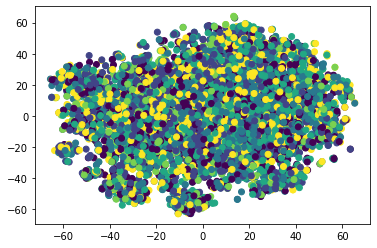

In [ ]:
tsne_results = tsne.fit_transform(Xtrain)
tsne_results = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
# tsne_results.shape
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=y_train)
plt.show();

# PCA

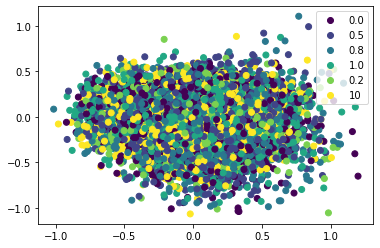

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 6)
# Xt = pca.fit_transform(features)
pca.fit(features)
Xt = pca.transform(features)

plot = plt.scatter(Xt[:,0], Xt[:,1], c=labels)
plt.legend(handles=plot.legend_elements()[0], labels=[0.0, 0.5, 0.8, 1.0, 0.2, 10])
plt.show()

<Figure size 480x480 with 0 Axes>

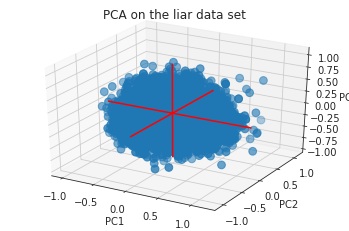

In [ ]:
# libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
 
# Get the iris dataset
sns.set_style("white")

# create figure
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 

# df['label']=pd.Categorical(df['label'])
# my_color=df['label'].cat.codes
# # df3 = df3.drop('label', 1)
 
# Run The PCA
pca = PCA(n_components=3)
pca.fit(features)
 
# Store results of PCA in a data frame
result=pd.DataFrame(pca.transform(features), columns=['PCA%i' % i for i in range(3)], index=df.index)
 
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], cmap="Set2_r", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the liar data set")
plt.show()

In [ ]:
import matplotlib
matplotlib.use('template')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 2
h = 0.02
X = features
y = labels

X_float = X.astype(np.float)
X_float

# # X_float.shape

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_float, y)



# calculate min, max and limits
x_min, x_max = X_float[:, 0].min() - 1, X_float[:, 0].max() + 1
y_min, y_max = X_float[:, 1].min() - 1, X_float[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# xx.ravel
# X_float[:, 0]
# last_column = np.c_[X_float, y]
# last_column = last_column[: , -1]

# last_column

# # predict class using data and kNN classifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])


# # Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# # Plot also the training points
plt.scatter(X_float[:, 0], X_float[:, 1], c=y, cmap=cmap_bold)
plt.xlim(X_float.min(), X_float.max())
# plt.ylim(y.min(), y.max())
plt.title("(k = %i)" % (n_neighbors))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


ValueError: ignored

# DF_TEST Created for experimenting with different dataset

In [ ]:
df_test = pd.read_csv('test.tsv',sep='\t', header=None)

In [ ]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
df_test.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]

In [ ]:
df_test.shape

(1267, 14)

In [ ]:
df_test.reset_index()
for i in df_test['statement'].index:
  with open('./drive/MyDrive/Liar_project/test/statements_test/s2/'+ '{0:03}'.format(i) + '.txt', 'w') as f:
    f.write(df_test['statement'][i])

KeyboardInterrupt: ignored

In [ ]:
%%shell

cd drive/MyDrive/Liar_project/test

bash go_test.sh

In [ ]:
y = df_test['label']
print(y.shape)
print(y.head())

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(y.shape)
print(y)

In [ ]:
features = np.loadtxt("./drive/MyDrive/Liar_project/test/docvectors.txt")

In [ ]:
features.shape

In [ ]:
features

In [ ]:
features = features[0:998]

In [ ]:
df_test['ZipLen'] = df_test['statement'].astype(str).map(len)


In [ ]:
df_test.head()

In [ ]:
len_sent = df_test['ZipLen']
len_sent.hist(figsize=[14,6])

In [ ]:
df_test = df_test[df_test.ZipLen < 1000]

In [ ]:
df_test.shape

In [ ]:
testing = features[750:]
testing.shape

In [ ]:
features_train = features[0:750]
features_train.shape

In [ ]:
# features_3 = features_2[:-30, :]
# features_3.shape

In [ ]:
# labels = df['label']
# labels.shape

In [ ]:
test_label = y[750:]
test_label.shape

In [ ]:
labels = y[0:750]
labels.shape

In [ ]:
# df['label'] = df['label'].astype('category')
# df['label'] = df['label'].cat.codes
# df['label']

# Bert Model


In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Testing the model with first 100 rows
batch_1 = df[:100]

In [ ]:
batch_1.head(10)

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
5,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
6,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
7,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
8,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,,,organization,0.0,0.0,1.0,0.0,1.0,a website
9,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video


In [ ]:
# batch_1['statement'].value_counts()

In [ ]:
tokenized_batch_1 = batch_1['statement'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                                           truncation=True)))

In [ ]:
max_len = 0
for i in tokenized_batch_1.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized_batch_1.values])

In [ ]:
np.array(padded).shape

(1000, 75)

In [ ]:
padded

array([[  101,  2758,  1996, ...,     0,     0,     0],
       [  101,  2043,  2106, ...,     0,     0,     0],
       [  101, 18520,  7207, ...,     0,     0,     0],
       ...,
       [  101,  1996,  2779, ...,     0,     0,     0],
       [  101,  2144,  3380, ...,     0,     0,     0],
       [  101,  1037, 18921, ...,   102,     0,     0]])

In [ ]:
attention_mask = np.where(padded != 0,1, 0)
attention_mask.shape

(1000, 75)

In [ ]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0]])

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
last_hidden_states 

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[-0.2034, -0.0399, -0.0438,  ..., -0.2690,  0.3456,  0.0173],
                                                        [ 0.3519,  0.3231, -0.3224,  ..., -0.3651,  0.4999, -0.0860],
                                                        [-0.3927, -0.6581, -0.6143,  ...,  0.2855,  0.3593, -0.1995],
                                                        ...,
                                                        [ 0.2783, -0.3895,  0.3903,  ..., -0.0239, -0.3260, -0.0106],
                                                        [ 0.5399, -0.0742,  0.1766,  ...,  0.1548,  0.0483, -0.0924],
                                                        [ 0.6350, -0.3647,  0.4544,  ...,  0.0165, -0.2840, -0.2105]],
                                               
                                                       [[-0.2093,  0.0138, -0.2853,  ..., -0.4826,  0.9367,  0.550

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
features.shape

(1000, 768)

In [ ]:
batch_1['label'] = batch_1['label'].replace(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'],[0, 5, 8, 10, 2, -10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
labels = batch_1['label']

In [ ]:
labels

0      1
1      2
2      3
3      1
4      2
      ..
995    1
996    0
997    3
998    2
999    0
Name: label, Length: 1000, dtype: int8

In [ ]:
# df2 = df[:100]

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 

import seaborn as sns
%matplotlib inline

X = list(features)

X_embedded = TSNE(n_components=2).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=labels.values)

In [ ]:
df_embeddings = df_embeddings.assign(text=df3.statement.values)

In [ ]:
import plotly.express as px

fig = px.scatter(
     df_embeddings, x='x', y='y',
     color='label', labels={'color': 'label'},
     hover_data= ['text'], title = 'GoEmotions Embedding Visualization')
fig.show()



In [1]:
    # # Use PCA to reduce dimensions to a number that's manageable for t-SNE
    # pca = PCA(n_components = 50, random_state = 7)
    # X1 = pca.fit_transform(features)
    # # X5 = pca.fit_transform(X5)
    # if row == 0: print("Shape after PCA: ", X1.shape)

In [2]:
# # Create a two dimensional t-SNE projection of the embeddings
# # tsne = TSNE(2, verbose=1)
# # tsne_proj = tsne.fit_transform(features)
# # Plot those points as a scatter plot and label them based on the pred labels
# cmap = cm.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(20,20))
# num_categories = 6
# for lab in range(num_categories):
#     indices = labels
#     ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(labels)).reshape(4,1000),label = labels ,alpha=0.5)
# ax.legend(fontsize='large', markerscale=0.5)
# plt.show()

In [3]:
# c=np.array(cmap(labels))
# c.shape